In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from model_file import get_pose_net
from model import BackBone
from torchvision import transforms, utils
from config import config
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import numpy as np
import os
import json
import cv2
import imutils
#--------------------------------------------------------------------------------------------------------------------------

C:\Users\Kartikaeya\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 134, 58]           2,368
       BatchNorm2d-2          [-1, 16, 134, 58]              32
              ReLU-3          [-1, 16, 134, 58]               0
              Conv-4          [-1, 16, 134, 58]               0
            Conv2d-5          [-1, 16, 134, 58]          12,560
       BatchNorm2d-6          [-1, 16, 134, 58]              32
              ReLU-7          [-1, 16, 134, 58]               0
              Conv-8          [-1, 16, 134, 58]               0
            Conv2d-9          [-1, 32, 134, 58]           4,640
      BatchNorm2d-10          [-1, 32, 134, 58]              64
             ReLU-11          [-1, 32, 134, 58]               0
             Conv-12          [-1, 32, 134, 58]               0
           Conv2d-13           [-1, 64, 67, 29]          18,496
      BatchNorm2d-14           [-1, 64,

In [2]:
class Pose_Dataset(Dataset):
    def __init__(self, annotations_path, img_path, transform = None):
        f = open(annotations_path, 'r')
        self.all_annotations = json.load(f)
        self.keypoints = self.all_annotations['annotations']
        f.close()
        self.annnotations_path = annotations_path
        self.img_path = img_path
        self.transform = transform
    def __len__(self):
        return len(self.keypoints)
    def __getitem__(self, idx):
        def form_gaussian_batch(sigma, kpts, img):
            batch = np.zeros((img.shape[0], img.shape[1], 17))
            for i in range(0,17):
                batch[:, :, i] = get_gaussian(img.shape, kpts[i, 0], kpts[i, 1], sigma)
            return batch
    
        def get_gaussian(output_shape, x, y, sigma):
            xx, yy= np.meshgrid(np.arange(output_shape[1]), np.arange(output_shape[0]))
            return ((1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-(yy-y)**2/(2*sigma**2)))*((1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-(xx-x)**2/(2*sigma**2)))
        
        if torch.is_tensor(idx):
            idx = idx.to_list()
        anns = self.keypoints[idx]
        image = cv2.imread(os.path.join(self.img_path, anns['image_name']))
        image = cv2.resize(image, (0,0), fx = 0.2, fy = 0.2)
        bbox = anns['bbox']
        cropped_img = image[bbox[1]:(bbox[1]+bbox[3]), bbox[0]:(bbox[0]+bbox[2])]
        
        kpts = np.array(anns['keypoints'], dtype = np.int32)
        kpts = np.reshape(kpts, (17,3))
        kpts[:, 0] = kpts[:, 0] - int(bbox[0])
        kpts[:, 1] = kpts[:, 1] - int(bbox[1])
        # now generate gaussian maps as target
        sigmas = [13, 6.5, 3, 1.5]
        target = []
        for sigma in sigmas:
            target.append(form_gaussian_batch(sigma, kpts, cropped_img))
        sample = {'image' : cropped_img, 'target' : target}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
#--------------------------------------------------------------------------------------------------------------------------

In [3]:
def my_collate(Batch):
    image = []
    targets = []
    for item in Batch:
        img = item['image']
        if(img.shape[1] * img.shape[2] < 10000):
            continue
        image.append(img)
        targets.append(item['target'])
    return {'image' : image , 'target' : targets}
#--------------------------------------------------------------------------------------------------------------------------

In [4]:
class RandomFlip(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        if(np.random.random_sample() > self.p):
            flipped_image = cv2.flip(image, 1)
            flipped_target = []
            for batch in target:
                flipped_batch = np.zeros(batch.shape)
                for i in range(0, 17):
                    flipped_batch[:, :, i] = cv2.flip(batch[:, :, i], 1)
                corrected_batch = np.zeros(batch.shape)
                corrected_batch[:, :, 0] = flipped_batch[:, :, 0]
                for j in range(1, 9):
                    corrected_batch[:, :, ((2*j) -1)] = flipped_batch[:, :, (2*j)]
                    corrected_batch[:, :, (2*j)] = flipped_batch[:, :, ((2*j) -1)]
                flipped_target.append(corrected_batch)
            return {'image' : flipped_image, 'target' : flipped_target}
        return sample
#--------------------------------------------------------------------------------------------------------------------------

In [5]:
class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        angle = np.random.random_sample()*self.degree
        angle = angle if (np.random.random_sample() > 0.5) else (-1 * angle)
        rotated_image = imutils.rotate_bound(np.float32(image)/255, angle = angle)
        rotated_target = []
        for batch in target:
            h, w = imutils.rotate_bound(np.float32(batch[:, :, 0]), angle = angle).shape
            rotated_batch = np.zeros((h, w, 17))
            for i in range(0, 17):
                rotated_batch[:, :, i] = imutils.rotate_bound(np.float32(batch[:, :, i]), angle = angle)
            rotated_target.append(rotated_batch)
        return {'image' : rotated_image, 'target' : rotated_target}
#--------------------------------------------------------------------------------------------------------------------------

In [6]:
class ToTensor(object):
    def __call__(self, sample):
        image, targets = sample['image'], sample['target']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        tensor_targets = []
        for batch in targets:
            tensor_targets.append(torch.from_numpy(batch)) 
        return {'image': image,
                'target': tensor_targets}

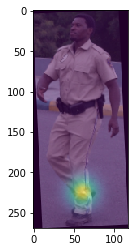

In [7]:
if __name__ == '__main__':
    
    pose_keypoints = Pose_Dataset(annotations_path = '../annotations/vru_keypoints_val_copy.json',
                      img_path = '../images/val',
                      transform = transforms.Compose([
                          RandomFlip(0.5),
                          RandomRotate(degree = 10),
                          ToTensor()
                      ]))
    
    train_loader = DataLoader(pose_keypoints, batch_size = 8, shuffle = False, collate_fn = my_collate
                             )
    #--------------------------------------------------------------------------------------------------------------------------

    batch_data = next(iter(train_loader))
    img = batch_data['image'][1]
    #--------------------------------------------------------------------------------------------------------------------------
    plt.imshow(np.transpose(img, (1,2,0))[:, :, [2, 1, 0]])
    anno = batch_data['target'][1][0][:, :, 16]
    plt.imshow(anno, alpha = 0.5)
    #--------------------------------------------------------------------------------------------------------------------------

In [8]:
model = BackBone().cuda()
summary(model, (3, 269, 117))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 134, 58]           2,368
       BatchNorm2d-2          [-1, 16, 134, 58]              32
              ReLU-3          [-1, 16, 134, 58]               0
              Conv-4          [-1, 16, 134, 58]               0
            Conv2d-5          [-1, 16, 134, 58]          12,560
       BatchNorm2d-6          [-1, 16, 134, 58]              32
              ReLU-7          [-1, 16, 134, 58]               0
              Conv-8          [-1, 16, 134, 58]               0
            Conv2d-9          [-1, 32, 134, 58]           4,640
      BatchNorm2d-10          [-1, 32, 134, 58]              64
             ReLU-11          [-1, 32, 134, 58]               0
             Conv-12          [-1, 32, 134, 58]               0
           Conv2d-13           [-1, 64, 67, 29]          18,496
      BatchNorm2d-14           [-1, 64,

In [9]:
data = iter(train_loader).next()
images = data['image']
# print(type(images[0]))
writer = SummaryWriter('runs/experiment1')
writer.add_graph(model, images[0][None, : , :, :].to('cuda'))
writer.close()

C:\Users\Kartikaeya\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
